# Neural Nets
## Manual implementation

In [226]:
%matplotlib inline
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd


In [227]:
#New complete class, with changes:
class Neural_Network(object):
    def __init__(self, Lambda=0):        
        #Define Hyperparameters
        self.inputLayerSize = 5
        self.outputLayerSize = 1
        self.hiddenLayerSize1 = 20
        self.hiddenLayerSize2 = 10
        
        #Weights (parameters)
        self.W1 = np.random.randn(self.inputLayerSize,self.hiddenLayerSize1)
        self.W2 = np.random.randn(self.hiddenLayerSize1,self.hiddenLayerSize2)
        self.W3 = np.random.randn(self.hiddenLayerSize2,self.outputLayerSize)
        
        #Regularization Parameter:
        self.Lambda = Lambda
        
    def forward(self, X):
        #Propogate inputs through network
        self.z2 = np.dot(X, self.W1)
        self.a2 = self.sigmoid(self.z2)
        self.z3 = np.dot(self.a2, self.W2)
        self.a3 = self.sigmoid(self.z3)
        self.z4 = np.dot(self.a3, self.W3)
        yHat = self.sigmoid(self.z4) 
        return yHat
        
    def sigmoid(self, z):
        #Apply sigmoid activation function to scalar, vector, or matrix
        return 1/(1+np.exp(-z))
    
    def sigmoidPrime(self,z):
        #Gradient of sigmoid
        return np.exp(-z)/((1+np.exp(-z))**2)
    
    def costFunction(self, X, y):
        #Compute cost for given X,y, use weights already stored in class.
        self.yHat = self.forward(X)
        J = 0.5*sum((y-self.yHat)**2)/X.shape[0] + (self.Lambda/2)*(np.sum(self.W1**2)+np.sum(self.W2**2)+np.sum(self.W3**2))
        return J
        
    def costFunctionPrime(self, X, y):
        #Compute derivative with respect to W and W2 for a given X and y:
        self.yHat = self.forward(X)
        
        delta4 = np.multiply(-(y-self.yHat), self.sigmoidPrime(self.z4))
        #Add gradient of regularization term:
        dJdW3 = np.dot(self.a3.T, delta4)/X.shape[0] + self.Lambda*self.W3
        
        delta3 = np.dot(delta4, self.W3.T)*self.sigmoidPrime(self.z3)
        #Add gradient of regularization term:
        dJdW2 = np.dot(self.a2.T, delta3)/X.shape[0] + self.Lambda*self.W2
        
        delta2 = np.dot(delta3, self.W2.T)*self.sigmoidPrime(self.z2)
        #Add gradient of regularization term:
        dJdW1 = np.dot(X.T, delta2)/X.shape[0] + self.Lambda*self.W1
        
        return dJdW1, dJdW2, dJdW3 
    
    #Helper functions for interacting with other methods/classes
    def getParams(self):
        #Get W1 and W2 Rolled into vector:
        params = np.concatenate((self.W1.ravel(), self.W2.ravel(), self.W3.ravel()))
        return params
    
    def setParams(self, params):
        #Set W1 and W2 using single parameter vector:
        W1_start = 0
        W1_end = self.hiddenLayerSize1*self.inputLayerSize
        self.W1 = np.reshape(params[W1_start:W1_end], \
                             (self.inputLayerSize, self.hiddenLayerSize1))
        W2_end = W1_end + self.hiddenLayerSize1*self.hiddenLayerSize2
        self.W2 = np.reshape(params[W1_end:W2_end], \
                             (self.hiddenLayerSize1, self.hiddenLayerSize2))
        W3_end = W2_end + self.hiddenLayerSize2*self.outputLayerSize
        self.W3 = np.reshape(params[W2_end:W3_end], \
                             (self.hiddenLayerSize2, self.outputLayerSize))
        
    def computeGradients(self, X, y):
        dJdW1, dJdW2, dJdW3 = self.costFunctionPrime(X, y)
        return np.concatenate((dJdW1.ravel(), dJdW2.ravel(), dJdW3.ravel()))

In [228]:
def computeNumericalGradient(N, X, y):
        paramsInitial = N.getParams()
        numgrad = np.zeros(paramsInitial.shape)
        perturb = np.zeros(paramsInitial.shape)
        e = 1e-4

        for p in range(len(paramsInitial)):
            #Set perturbation vector
            perturb[p] = e
            N.setParams(paramsInitial + perturb)
            loss2 = N.costFunction(X, y)
            
            N.setParams(paramsInitial - perturb)
            loss1 = N.costFunction(X, y)

            #Compute Numerical Gradient
            numgrad[p] = (loss2 - loss1) / (2*e)

            #Return the value we changed to zero:
            perturb[p] = 0
            
        #Return Params to original value:
        N.setParams(paramsInitial)

        return numgrad

In [229]:
##Need to modify trainer class a bit to check testing error during training:
class trainer(object):
    def __init__(self, N):
        #Make Local reference to network:
        self.N = N
        
    def callbackF(self, params):
        self.N.setParams(params)
        self.J.append(self.N.costFunction(self.X, self.y))
        self.testJ.append(self.N.costFunction(self.testX, self.testY))
        
    def costFunctionWrapper(self, params, X, y):
        self.N.setParams(params)
        cost = self.N.costFunction(X, y)
        grad = self.N.computeGradients(X,y)
        
        return cost, grad
        
    def fit(self, trainX, trainY):
        #Make an internal variable for the callback function:
        self.X = trainX
        self.y = trainY
        
        self.testX = testX
        self.testY = testY

        #Make empty list to store training costs:
        self.J = []
        self.testJ = []
        
        params0 = self.N.getParams()

        options = {'maxiter': 200, 'disp' : True}
        _res = optimize.minimize(self.costFunctionWrapper, params0, jac=True, method='BFGS', \
                                 args=(trainX, trainY), options=options, callback=self.callbackF)

        self.N.setParams(_res.x)
        self.optimizationResults = _res
        
        return self
        
    def predict(self, testX):
        return np.apply_along_axis(self.N.forward, 1, testX)

In [230]:
from sklearn.model_selection import train_test_split


df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data', 
                 header=None, 
                 sep='\s+')
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 
                 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 
                 'TAX', 'PTRATIO', 'B', 'LSTAT', 'MEDV']
df.columns = feature_names

X = df[['RM', 'LSTAT', 'NOX', 'TAX', 'PTRATIO']].values
y = df[['MEDV']].values

X /= np.amax(X, axis=0)
y /= np.amax(y, axis=0)

trainX, testX, trainY, testY = train_test_split(X, y)

In [231]:
#Train network with new data:
NN = Neural_Network(Lambda=0.0001)

In [232]:
#Make sure our gradients our correct after making changes:
numgrad = computeNumericalGradient(NN, trainX, trainY)
grad = NN.computeGradients(trainX, trainY)

In [233]:
#Should be less than 1e-8:
if np.linalg.norm(grad-numgrad)/np.linalg.norm(grad+numgrad) < 1e-8:
    print('Nice result!')
else:
    print('Bad result:(')

Nice result!


In [234]:
T = trainer(NN)

In [235]:
T = T.fit(trainX,trainY)

Optimization terminated successfully.
         Current function value: 0.006815
         Iterations: 139
         Function evaluations: 145
         Gradient evaluations: 145


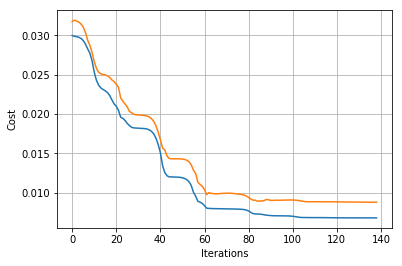

In [236]:
plt.plot(T.J)
plt.plot(T.testJ)
plt.grid(1)
plt.xlabel('Iterations')
plt.ylabel('Cost')
plt.show()

In [237]:
y_pred = T.predict(testX)

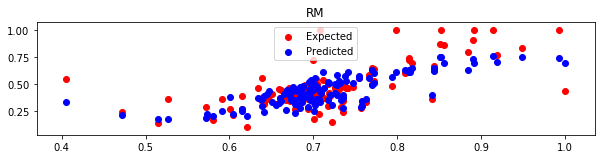

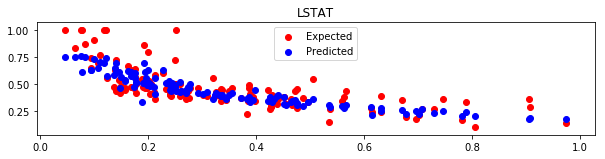

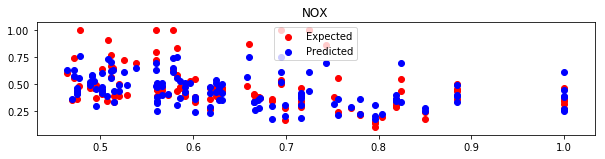

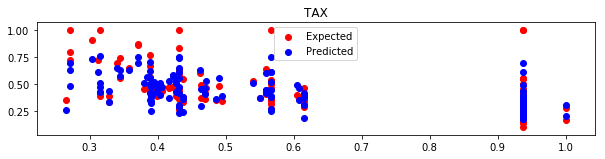

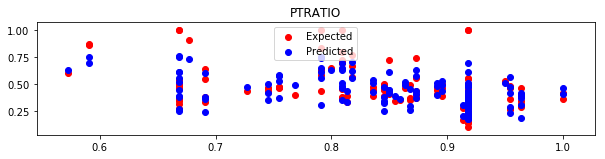

In [238]:
for t, i in zip(['RM', 'LSTAT', 'NOX', 'TAX', 'PTRATIO'], range(testX.shape[1])):
    plt.figure(figsize=(10,12))
    plt.subplot(5,1,i+1)
    plt.title(t)
    plt.scatter(testX[:,i], testY, c='r', label='Expected')
    plt.scatter(testX[:,i], y_pred, c='b', label='Predicted')
    plt.legend(loc='upper center')
plt.show()

In [273]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


mse = mean_squared_error(testY, y_pred)
mae = mean_absolute_error(testY, y_pred)
print(f'Mean Squared Error: {mse}',
     f' Mean Absolute Error: {mae}')

Mean Squared Error: 0.975937716514584  Mean Absolute Error: 0.8428197870829544


## Keras implementation

In [267]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers


model = Sequential()
model.add(Dense(20, input_dim=5, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(10, kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='normal', activation='sigmoid'))
model.compile(loss='mean_squared_error', optimizer=optimizers.SGD(lr=0.0001))

In [271]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.preprocessing import StandardScaler

def model_wrap():
    return model

sc = StandardScaler()
trainX = sc.fit_transform(trainX)
trainY = sc.fit_transform(trainY)
testX = sc.fit_transform(testX)
testY = sc.fit_transform(testY)

kr = KerasRegressor(build_fn=model_wrap, epochs=100, verbose=0, validation_data=(testX, testY))
kr.fit(trainX, trainY)
y_pred_ks = kr.predict(testX)


mse = mean_squared_error(testY, kr.predict(testX))
mae = mean_absolute_error(testY, kr.predict(testX))
print(f'Mean Squared Error: {mse}',
     f' Mean Absolute Error: {mae}')

Mean Squared Error: 1.1746001371838062  Mean Absolute Error: 0.9060428082045358
